# Importation de bibliothèques

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import matplotlib as mlt
import seaborn as sns
from math import floor
from datetime import date
from datetime import datetime
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.models.annotations import Arrow
from bokeh.models.arrow_heads import OpenHead, NormalHead, VeeHead
from bokeh.models.annotations import Label
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [0]:
output_notebook()

# Définition de fonctions

In [0]:
#à partir d'un dataframe référençant des valeurs par pays
#retourne un dataframe avec les totaux de la colonnes d'intêret par années
def getTotalDataframe(dataframe, column, indicator):
  cleanedDataset = dataframe[dataframe[column] == indicator].dropna(how = 'all', axis = 1).dropna(how = 'any', axis = 0)
  totalSerie = cleanedDataset.select_dtypes(pd.np.number).sum().rename('Total_' + indicator)
  
  return pd.DataFrame(totalSerie)

#à partir d'un dataframe dont les colonnes sont de type : <année> | <valeurs>
#affiche une courbe avec <année> en abscisse et <valeurs> en ordonnée 
def lineDataframe(fig, dataframe, title, xaxis, yaxis):
  x = dataframe.index.values
  y = dataframe[0:].values.flatten()
  
  fig.xaxis.major_label_text_font_size = fig.yaxis.major_label_text_font_size = "15pt"
  fig.xaxis.axis_label_text_font_size = fig.yaxis.axis_label_text_font_size = "20pt"
  fig.title.text_font_size = "30pt"
  fig.xaxis.axis_label = xaxis
  fig.yaxis.axis_label = yaxis
  fig.title.text = title
  fig.plot_width=1100
  fig.plot_height=500

  fig.line(x, y, color='navy', line_width=2, legend='Valeurs mesurées')
  fig.legend.location = "top_center"
  fig.legend.label_text_font_size = '15pt'

#à partir d'un intervalle de prédiciton et d'un dataframe dont les colonnes sont de type : <année> | <valeurs>
#affiche une régression liénaire avec <année> en abscisse et <valeurs> en ordonnée 
def lineLinearRegression(fig, dataframe, rangeToPredict):
  x = dataframe.index.values
  y = dataframe[0:].values.flatten()
  
  x_reshaped = x.reshape(-1, 1)
  model = LinearRegression()
  
  model.fit(x_reshaped, y)
  x_pred = np.append(x, rangeToPredict)
  fig.line(x_pred, model.predict(x_pred.reshape(-1, 1)), color='purple', line_dash="dashed", line_width=1.5, legend='Régression linéaire')
  fig.legend.location = "top_center"
  fig.legend.label_text_font_size = '15pt'

#à partir d'un intervalle de prédiciton et d'un dataframe dont les colonnes sont de type : <année> | <valeurs>
#affiche une régression polynomiale avec <année> en abscisse et <valeurs> en ordonnée 
def linePolynomialRegression(fig, dataframe, rangeToPredict):
  x = dataframe.index.values
  y = dataframe[0:].values.flatten()
  
  x_reshaped = x.reshape(-1, 1)
  poly_features = PolynomialFeatures(degree=3, include_bias=False)
  x_poly = poly_features.fit_transform(x_reshaped)
  poly_features.fit(x_poly, y)
  model = LinearRegression()
  model.fit(x_poly, y)
  
  x_pred = np.append(x, rangeToPredict)
  fig.line(x_pred, model.predict(poly_features.fit_transform(x_pred.reshape(-1, 1))), color='red', line_dash="dashed", line_width=1.5, legend='Régression polynomiale')
  fig.legend.location = "top_center"
  fig.legend.label_text_font_size = '15pt'

#à partir d'un intervalle de prédiciton et d'une liste de dataframes dont les colonnes sont de type : <année> | <valeurs>
#retourne une concaténation de ces dataframes de type : <année> | <valeurs1> | <valeurs2> | ...
def getJoinedDataframe(listDataframe):
  listDataframeToJoin = []
  
  for dataframe in listDataframe:
    dataframe.index = dataframe.index.astype(np.int64)
    listDataframeToJoin.append(dataframe)
  
  joinedDataframe = pd.concat(listDataframeToJoin, axis=1)
    
  joinedDataframeCleaned = joinedDataframe.dropna(how = 'all', axis = 1).dropna(how = 'any', axis = 0)
  
  return joinedDataframeCleaned

#à partir d'un nom de colonne d'intêret et d'un dataframe de type : <année> | <valeurs1> | <valeurs2> | ...
#retourne le dataframe de corrélation nettoyé (prêt à l'affichage) 
def getCorrelationDataframe(dataframe, column):
  correlationSerie = dataframe.corr()[column]
  sortedCorrelationSerie = correlationSerie.sort_values(ascending = False)
  
  correlationDataframe = pd.DataFrame(sortedCorrelationSerie)

  return correlationDataframe

def vbarDataframe(dataframe):
  dataframe.reset_index(inplace=True)
  dataframe.rename(columns={'index': 'Valeur d\'intéret', dataframe.columns[1]: 'Corrélation'}, inplace=True)
  dataframe.loc[dataframe['Corrélation'] < 0, 'Type de corrélation'] = 'Corrélation négative'
  dataframe.loc[dataframe['Corrélation'] >= 0, 'Type de corrélation'] = 'Corrélation positive'
  dataframe.loc[dataframe['Corrélation'] < 0, 'Corrélation'] = abs(dataframe['Corrélation'])
  dataframe.drop([0], inplace=True)

  g = sns.barplot(x='Valeur d\'intéret', y='Corrélation', hue='Type de corrélation', data=dataframe)
  g.axes.set_title('Corrélation en fonction de la population mondiale', fontsize=28)
  
  for column in dataframe.columns:
    ticklabels_list = []
    for ticklabel in g.get_xticklabels():
      ticklabel_text = ticklabel.get_text()
      ticklabel_length = floor(len(ticklabel_text) / 2)
      index = 0
      while index < ticklabel_length and ticklabel_text[index] != ' ':
        index += 1
      if index < ticklabel_length:
        ticklabels_list.append(ticklabel_text[:index] + '\n' + ticklabel_text[index:])

  plt.legend(loc='upper center')
  plt.setp(g.get_legend().get_texts(), fontsize='15')
  g.set_xticklabels(ticklabels_list, rotation=20, fontsize=20)
  g.set_xlabel(g.get_xlabel(), fontsize=22)
  g.set_ylabel(g.get_ylabel(), fontsize=22)
  g.tick_params(labelsize=13)
  sns.set(rc={'figure.figsize':(13, 13)})

# Pas de changement

## Récupération, nettoyage et mise en forme du dataset

### Températures globales

In [0]:
#on importe notre jeu de données
global_temperature = pd.read_csv("http://swam.fr/dataset/temp_global.csv")
global_temperature.sort_values(by=["Year"],ascending= True, inplace=True)

global_temperature.head()

,Source,Year,Mean
273,GISTEMP,1880,-0.2000
272,GCAG,1880,-0.1148
270,GCAG,1881,-0.0628
271,GISTEMP,1881,-0.1200
268,GCAG,1882,-0.0648


In [0]:
#on sépare le jeu de données en deux en fonction des différents organismes qui ont participés aux mesures
gcag = global_temperature[global_temperature['Source'] == 'GCAG']#on selectionne uniquement les données dela source GACG

#mise en forme du jeu de donnée pour l'affichage
df_gcag = gcag.drop(columns = 'Source').set_index('Year')
df_gcag.columns.values[0] = 'Températures globales (GCAG)'
df_gcag.head()

,Températures globales (GCAG)
Year,
1880,-0.1148
1881,-0.0628
1882,-0.0648
1883,-0.1424
1884,-0.2009


In [0]:
#on selectionne uniquement les données de la source GISTEMP
gistemp = global_temperature[global_temperature['Source'] == 'GISTEMP']

#mise en forme des données pour l'affichage
df_gistemp = gistemp.drop(columns = 'Source').set_index('Year')
df_gistemp.columns.values[0] = 'Températures globales (GISTEMP)'
df_gistemp.head()

,Températures globales (GISTEMP)
Year,
1880,-0.20
1881,-0.12
1882,-0.10
1883,-0.21
1884,-0.28


### Rensement de la population

In [0]:
ges_deforestation_population = pd.read_csv('http://swam.fr/dataset/ges_deforestation_population.csv', skiprows=4)
df_population = getTotalDataframe(ges_deforestation_population, "Indicator Code", "SP.POP.TOTL")
df_population.columns.values[0] = 'Recensement de la population mondiale'
df_population['Recensement de la population mondiale'] = df_population['Recensement de la population mondiale']
df_population.head()

,Recensement de la population mondiale
1960,3.069599e+10
1961,3.110732e+10
1962,3.165723e+10
1963,3.234173e+10
1964,3.303151e+10


## Observations graphiques


In [0]:
global_temp_gcag_fig = figure()
global_temp_gistemp_fig = figure()
population_fig = figure()

lineDataframe(global_temp_gcag_fig, df_gcag, "Températures globales de surface par le GCAG", "Année", "Anomalie de température (°C)")
lineDataframe(global_temp_gistemp_fig, df_gistemp, "Températures globales de surface par le GISTEMP", "Année", "Anomalie de température (°C)")
lineDataframe(population_fig, df_population, "Évolution de la population mondiale", "Année", "Recensement de la population")

show(global_temp_gcag_fig)
show(global_temp_gistemp_fig)
show(population_fig)


## Extrapolation jusqu'en 2050

In [0]:
global_temp_extrapolation = list(map(float, range(2017, 2050, 1)))

linePolynomialRegression(global_temp_gcag_fig, df_gcag, global_temp_extrapolation)
lineLinearRegression(global_temp_gcag_fig, df_gcag, global_temp_extrapolation)

linePolynomialRegression(global_temp_gistemp_fig, df_gcag, global_temp_extrapolation)
lineLinearRegression(global_temp_gistemp_fig, df_gcag, global_temp_extrapolation)

linePolynomialRegression(population_fig, df_population, global_temp_extrapolation)
lineLinearRegression(population_fig, df_population, global_temp_extrapolation)

show(global_temp_gcag_fig)
show(global_temp_gistemp_fig)
show(population_fig)

# Pas nous

## Récupération, nettoyage et mise en forme des datasets

### Émission de CO2 d'origine fossiles

In [0]:
co2_fossile = pd.read_csv("http://swam.fr/dataset/co2_fossil.csv")
co2_fossile.head()

,Year,Country,Total,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels (Not in Total)
0,1751,UNITED KINGDOM,2552,2552,0,0,0,0,0.0,0
1,1752,UNITED KINGDOM,2553,2553,0,0,0,0,0.0,0
2,1753,UNITED KINGDOM,2553,2553,0,0,0,0,0.0,0
3,1754,UNITED KINGDOM,2554,2554,0,0,0,0,0.0,0
4,1755,UNITED KINGDOM,2555,2555,0,0,0,0,0.0,0


In [0]:
#on regroupe les valeurs par année et on en fait la moyenne
co2_fossile_year = co2_fossile.groupby(by = 'Year').mean()

#on reset l'index pour retrouver les années en colonnes
co2_fossile_year = pd.DataFrame.reset_index(co2_fossile_year)
co2_fossile_year.head()


,Year,Total,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels (Not in Total)
0,1751,2552.0,2552.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1752,2553.0,2553.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1753,2553.0,2553.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1754,2554.0,2554.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1755,2555.0,2555.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#mise en forme des données pour l'affichage
df_co2_fossile = pd.DataFrame()
df_co2_fossile = co2_fossile_year.loc[:,('Year','Total')].set_index('Year')
df_co2_fossile.columns.values[0] = 'Émission de CO2 d\'origine fossile'
df_co2_fossile.tail()

,Émission de CO2 d'origine fossile
Year,
2010,40098.576037
2011,41670.963134
2012,41860.872727
2013,41976.395455
2014,42300.909091


### Concentration de l'atmosphère en CO2

In [0]:
#on importe le dataset sur la fraction molaire en CO2 de l'air atmosphérique
co2_frac_mol = pd.read_csv("http://swam.fr/dataset/co2_fraction_mol.csv")

#on transforme sa colonne 'Date' en format datetime
co2_frac_mol['Date'] = pd.to_datetime(co2_frac_mol['Date'])
co2_frac_mol.head()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958-03-01,1958.208,315.71,315.71,314.62,-1
1,1958-04-01,1958.292,317.45,317.45,315.29,-1
2,1958-05-01,1958.375,317.50,317.50,314.71,-1
3,1958-06-01,1958.458,-99.99,317.10,314.85,-1
4,1958-07-01,1958.542,315.86,315.86,314.98,-1


In [0]:
#du format datetime on extrait directement l'année 
co2_frac_mol['Year'] =  co2_frac_mol['Date'].dt.year

#on regroupe par la suite les données en fonction de leur année et on réalise la moyenne de ces dernières
co2_frac_mol_year = co2_frac_mol.groupby(by = 'Year').mean()

#on reset l'index pour retrouver l'année en colonne
co2_frac_mol_year = pd.DataFrame.reset_index(co2_frac_mol_year)
co2_frac_mol_year.head()

,Year,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958,1958.5833,232.267000,315.241000,315.283000,-1.0
1,1959,1959.5000,315.974167,315.974167,315.974167,-1.0
2,1960,1960.5000,316.907500,316.907500,316.907500,-1.0
3,1961,1961.5000,317.637500,317.637500,317.636667,-1.0
4,1962,1962.5000,318.450833,318.450833,318.450000,-1.0


In [0]:
#création du dataframe à passer à l'affichage
df_co2_atmo = pd.DataFrame()

#on lui ajoute les colonnes d'intérêt
df_co2_atmo = co2_frac_mol_year.loc[:,('Year','Trend')].set_index('Year')
df_co2_atmo.columns.values[0] = 'Concentration amosphérique de CO2'
df_co2_atmo.tail()

,Concentration amosphérique de CO2
Year,
2014,398.648333
2015,400.835000
2016,404.239167
2017,406.552500
2018,408.135556


## Observations graphiques

In [0]:
co2_fossile_fig = figure()
co2_atmo_fig = figure()

lineDataframe(co2_fossile_fig, df_co2_fossile, "Rejet de carbone d'origine fossile", "Année", "Rejet de CO2 (tonne métrique)")
lineDataframe(co2_atmo_fig, df_co2_atmo, "Concentration atmosphérique en CO2", "Année", "Concentration CO2 (mmol)")

show(co2_fossile_fig)
show(co2_atmo_fig)

## Extrapolation jusqu'en 2050

In [0]:
co2_extrapolation = list(map(float, range(2014, 2050, 1)))

linePolynomialRegression(co2_fossile_fig, df_co2_fossile, co2_extrapolation)
lineLinearRegression(co2_fossile_fig, df_co2_fossile, co2_extrapolation)

linePolynomialRegression(co2_atmo_fig, df_co2_atmo, co2_extrapolation)
lineLinearRegression(co2_atmo_fig, df_co2_atmo, co2_extrapolation)

show(co2_fossile_fig)
show(co2_atmo_fig)

# Pas grave

## Récupération, nettoyage et mise en forme des datasets

### Niveau de la mer

In [0]:
niveau_mer = pd.read_csv('https://pkgstore.datahub.io/core/sea-level-rise/epa-sea-level/archive/cc8c7c5517e91452e6629ab30bfd3d68/epa-sea-level.csv')
niveau_mer.tail()

,Year,CSIRO Adjusted Sea Level,Lower Error Bound,Upper Error Bound,NOAA Adjusted Sea Level
130,2010,8.901575,8.618110,9.185039,8.122973
131,2011,8.964567,8.661417,9.267717,8.053065
132,2012,9.326772,8.992126,9.661417,8.457058
133,2013,8.980315,8.622047,9.338583,8.546648
134,2014,NaN,NaN,NaN,8.663700


In [0]:
#création du dataframe à passer à l'affichage
df_sea_level = pd.DataFrame()

#on lui ajoute les colonnes d'intérêt
df_sea_level = niveau_mer.loc[:, ('Year', 'CSIRO Adjusted Sea Level')].dropna(how='any').set_index('Year')
df_sea_level.columns.values[0] = 'Niveau de la mer'
df_sea_level.head()

,Niveau de la mer
Year,
1880,0.000000
1881,0.220472
1882,-0.440945
1883,-0.232283
1884,0.590551


### Masse des glaciers

In [0]:
mass_glacier = pd.read_csv('http://swam.fr/dataset/masse_glaciers.csv')
mass_glacier.tail()

,Year,Mean cumulative mass balance,Number of observations
65,2010,-25.158,37.0
66,2011,-26.294,37.0
67,2012,-26.930,36.0
68,2013,-27.817,31.0
69,2014,-28.652,24.0


In [0]:
#création du dataframe à passer à l'affichage
df_mass_glacier = pd.DataFrame()

#on lui ajoute les colonnes d'intérêt
df_mass_glacier = mass_glacier.loc[:,("Year",'Mean cumulative mass balance')].set_index('Year')
df_mass_glacier.columns.values[0] = 'Masse des glaciers'
df_mass_glacier.head()

,Masse des glaciers
Year,
1945,0.00
1946,-1.13
1947,-3.19
1948,-3.19
1949,-3.82


### Nombre de désastres naturels

In [0]:
df_disaster = pd.read_csv('http://swam.fr/dataset/natural_disaster.csv', index_col=2, nrows=119).drop(['Entity', 'Code'], axis=1)
df_disaster.columns.values[0] = 'Nombre de désastres naturels'
df_disaster.tail()

,Nombre de désastres naturels
Year,
2014,320
2015,380
2016,325
2017,276
2018,282


### Surface forestière

In [0]:
df_forest_surface = getTotalDataframe(ges_deforestation_population, "Indicator Code", "AG.LND.FRST.ZS")
df_forest_surface.columns.values[0] = 'Surface forestière'
df_forest_surface.head()

,Surface forestière
1990,7880.249461
1991,7868.804693
1992,7857.632180
1993,7837.931389
1994,7836.058974


## Étude graphique

In [0]:
sea_level_fig = figure()
mass_glacier_fig = figure()
disaster_fig = figure()
forest_surface_fig = figure()

lineDataframe(sea_level_fig, df_sea_level, "Variation globales annuelles du niveau de la mer", "Année", "Variation du niveau de la mer (mm)")
lineDataframe(mass_glacier_fig, df_mass_glacier, "Évolution moyenne mondiale des masses de glaciers", "Année", "Masse globale moyenne des glaciers")
lineDataframe(disaster_fig, df_disaster, "Évolution du nombre de désastres naturels", "Année", "Nombre de désatres naturels")
lineDataframe(forest_surface_fig, df_forest_surface, "Évolution de la surface forestière", "Année", "Surface forestière (% du territoire)")

show(sea_level_fig)
show(mass_glacier_fig)
show(disaster_fig)
show(forest_surface_fig)


## Extrapolation jusqu'en 2050

In [0]:
pas_grave_extrapolation = list(map(float, range(2013, 2030, 1)))

linePolynomialRegression(sea_level_fig, df_sea_level, pas_grave_extrapolation)
lineLinearRegression(sea_level_fig, df_sea_level, pas_grave_extrapolation)

linePolynomialRegression(mass_glacier_fig, df_mass_glacier, pas_grave_extrapolation)
# lineLinearRegression(mass_glacier_fig, df_mass_glacier, pas_grave_extrapolation)

linePolynomialRegression(disaster_fig, df_disaster, pas_grave_extrapolation)
lineLinearRegression(disaster_fig, df_disaster, pas_grave_extrapolation)

show(sea_level_fig)
show(mass_glacier_fig)
show(disaster_fig)

# Corrélation entre les divers phénomènes observés

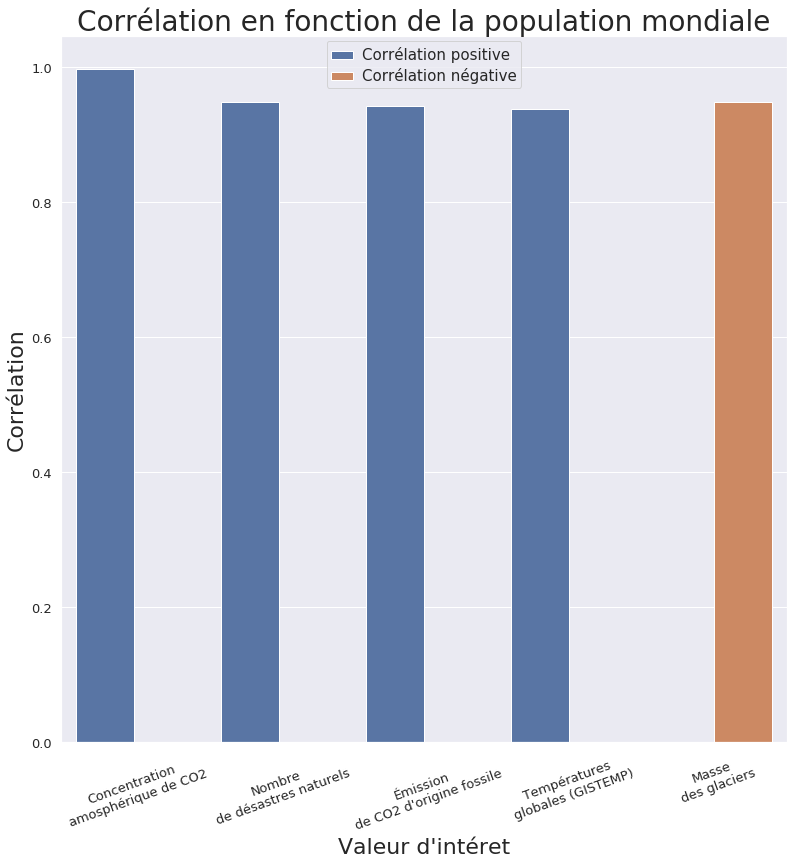

In [0]:
df_list = [df_population, df_gistemp, df_co2_fossile, df_co2_atmo, df_mass_glacier, df_disaster]
total_dataframe = getJoinedDataframe(df_list)
correlation_dataframe = getCorrelationDataframe(total_dataframe, 'Recensement de la population mondiale')
vbarDataframe(correlation_dataframe)